<a href="https://colab.research.google.com/github/b-remy/score-estimation-comparison/blob/master/notebooks/Flax_NCSNv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dm-haiku
!pip install flax

     |████████████████████████████████| 245kB 2.8MB/s 
     |████████████████████████████████| 92kB 2.4MB/s 


In [ ]:
%pylab inline
import haiku as hk
import jax
import jax.numpy as jnp

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import flax
from flax import nn

In [ ]:
@nn.module
def ResNetBlock(x, filters,
                conv, norm, act,
                strides=(1, 1)):
    """ResNet block template."""
    residual = x

    y = conv(x, filters, (3, 3), strides)
    y = norm(y)
    y = act(y)
    y = conv(y, filters, (3, 3))
    y = norm(y, scale_init=nn.initializers.zeros)

    if residual.shape != y.shape:
      residual = conv(residual, filters, (1, 1), strides, name='conv_proj')
      residual = norm(residual, name='norm_proj')

    return act(residual + y)

In [ ]:
@nn.module
def ConditionalResNetBlock(x, cond, filters,
                conv, norm, act,
                strides=(1, 1)):
    """ResNet block template."""
    residual = x

    y = conv(x, filters, (3, 3), strides)
    y = norm(y)
    y = act(y)
    y = conv(y, filters, (3, 3))
    y = norm(y, scale_init=nn.initializers.zeros)

    w = jnp.mean(y, axis=[1,2])
    w = jnp.concatenate([w, cond], axis=-1)
    w = act(nn.Dense(w, filters*2))
    w = jax.numpy.tanh(nn.Dense(w, filters))
    w = jnp.expand_dims(jnp.expand_dims(w,1),1)

    if residual.shape != y.shape:
      residual = conv(residual, filters, (1, 1), strides, name='conv_proj')
      residual = norm(residual, name='norm_proj')

    return act(residual + y*w)

In [ ]:
@nn.module
def ConvARDAE(x, sigma, stage_sizes=[2,2,2], num_filters=16, act=nn.leaky_relu, train=True):
  conv = nn.Conv.partial(bias=False, padding='SAME')
  conv_transpose = nn.ConvTranspose.partial(bias=False, padding='SAME')
  norm = nn.BatchNorm.partial(
        use_running_average=not train,
        momentum=0.9, epsilon=1e-5)
  
  x  = jnp.concatenate([x, sigma*jnp.ones_like(x)], axis=-1)
  net = conv(x, num_filters, (5,5), (2,2), name='conv_init')
  shortcuts = []
  for i, block_size in enumerate(stage_sizes):
    shortcuts.append(net)
    for j in range(block_size):
      strides = (2, 2) if i > 0 and j == 0 else (1, 1)
      net = ResNetBlock(net, num_filters * 2 ** i,
                    strides=strides,
                    conv=conv,
                    norm=norm, act=act)

  net = jnp.concatenate([net, sigma*jnp.ones_like(net)],axis=-1)

  for i, block_size in enumerate(stage_sizes):
    if i > 0:
      net = jnp.concatenate([net, shortcuts[-i]], axis=-1)
    for j in range(block_size):
      strides = (2, 2) if j == 0 else (1, 1)
      net = ResNetBlock(net, 
                        num_filters * 2 ** (len(stage_sizes) - i -1),
                        strides=strides,
                        conv=conv_transpose,
                        norm=norm, act=act)
      
  return nn.Conv(net, 1, (5,5), name='output')

In [ ]:
with flax.nn.stateful() as init_state:
  with flax.nn.stochastic(jax.random.PRNGKey(0)):
    _, initial_params = ConvARDAE.init_by_shape(
      jax.random.PRNGKey(0),
      [((1, 32, 32, 1), jnp.float32), ((1,1), jnp.float32)])
    model = flax.nn.Model(ConvARDAE, initial_params)

In [ ]:
import tensorflow_datasets as tfds
import jax.numpy as jnp

In [ ]:
# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [ ]:
# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.pad(train_images,((0,0),(2,2),(2,2),(0,0)))/255.

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.pad(test_images, ((0,0),(2,2),(2,2),(0,0)))/255.

In [ ]:
batch_size=128
delta = 0.5

def get_batch():
    y = train_images[np.random.choice(len(train_images), batch_size)].astype('float32')
    u = np.random.randn(batch_size, 32,32,1)
    s = delta * np.random.randn(batch_size, 1, 1, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

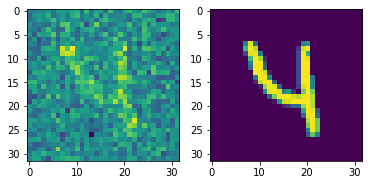

In [ ]:
batch = get_batch()
subplot(121)
imshow(batch['x'][0,...,0])
subplot(122)
imshow(batch['y'][0,...,0])

In [ ]:
batch['s'].shape

(128, 1, 1, 1)

In [ ]:
optimizer = flax.optim.Adam(learning_rate=0.001).create(model)
state = init_state
key = jax.random.PRNGKey(1)
losses=[]

In [ ]:
@jax.jit
def train_step(optimizer, state, batch, prng_key):
  def loss_fn(model):
    """loss function used for training."""
    with flax.nn.stateful(state) as new_state:
      with flax.nn.stochastic(prng_key):
        res = model(batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, new_state
  (l, new_state), grad = jax.value_and_grad(loss_fn, has_aux=True)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad, learning_rate=0.5e-4)
  return optimizer, new_state, l

In [ ]:
for i in range(100000):
  k, key = jax.random.split(key)
  batch = get_batch()
  optimizer, state, l = train_step(optimizer,  state, batch, k)
  losses.append(l)
  if i % 100==0:
    print(i, l)

0 0.08733664
100 0.080899216
200 0.086314365
300 0.08250992
400 0.07699368
500 0.070907354
600 0.07090924
700 0.092792325
800 0.08115998
900 0.09272176
1000 0.0775919
1100 0.07381866
1200 0.06784411
1300 0.07481449
1400 0.09243688
1500 0.086212635
1600 0.07922618
1700 0.0949237
1800 0.08607744
1900 0.07115059
2000 0.10042194
2100 0.08021186
2200 0.08135219
2300 0.074267045
2400 0.07408616
2500 0.087481305
2600 0.07068236
2700 0.082658835
2800 0.07899268
2900 0.08555015
3000 0.068965495
3100 0.09357381
3200 0.083307035
3300 0.07563417
3400 0.071362704
3500 0.11038386
3600 0.0719426
3700 0.08075033
3800 0.07879781
3900 0.073707
4000 0.071237005
4100 0.07276238
4200 0.08562445
4300 0.07361461
4400 0.08957692
4500 0.07974211
4600 0.08627392
4700 0.08490226
4800 0.103110164
4900 0.08092807
5000 0.06931655
5100 0.078117564
5200 0.078437954
5300 0.07330854
5400 0.09835813
5500 0.07666229
5600 0.08741255
5700 0.07542949
5800 0.07887564
5900 0.074994266
6000 0.07727264
6100 0.089218944
6200 0.0

KeyboardInterrupt: ignored

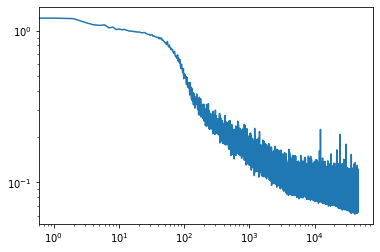

In [ ]:
loglog(losses)

In [ ]:
with flax.nn.stateful(state, mutable=False):
  res =  optimizer.target(batch['x'], batch['s'], train=False)

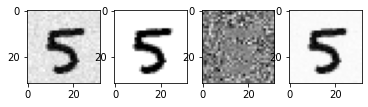

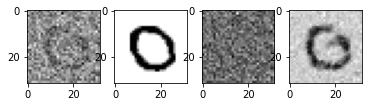

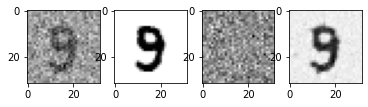

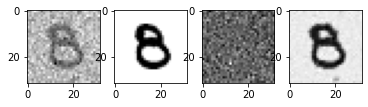

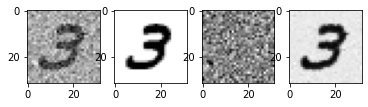

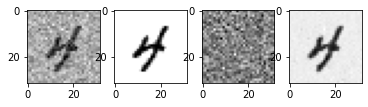

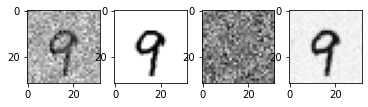

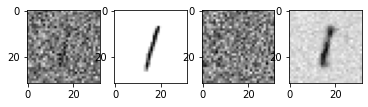

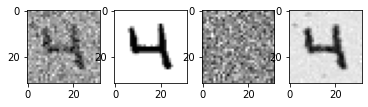

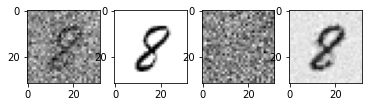

In [ ]:
for i in range(10):
  ind = i
  figure()
  subplot(141)
  imshow(batch['x'][ind,...,0],cmap='gray_r')
  subplot(142)
  imshow(batch['y'][ind,...,0],cmap='gray_r')
  subplot(143)
  imshow(res[ind,...,0],cmap='gray_r')
  subplot(144)
  imshow(batch['x'][ind,...,0] + batch['s'][ind,:,:,0]**2 * res[ind,...,0],cmap='gray_r')

Ok, that looks good :-)

## Next step, sampling \o/ 

In [ ]:
#@title Run me

import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

__all__ = [
    'ScoreUncalibratedHamiltonianMonteCarlo',
    'ScoreUncalibratedLangevin',
    'ScoreHamitonianMonteCarlo',
    'ScoreMetropolisAdjustedLangevinAlgorithm'
]

class ScoreUncalibratedHamiltonianMonteCarlo(tfp.mcmc.UncalibratedHamiltonianMonteCarlo):
  def __init__(self,
               target_score_fn,
               step_size,
               num_leapfrog_steps,
               num_delta_logp_steps,
               state_gradients_are_stopped=False,
               seed=None,
               store_parameters_in_results=False,
               name=None):
    # We begin by creating a fake logp, with the correct scores
    @jax.custom_jvp
    def fake_logp(x):
      return 0.
    @fake_logp.defjvp
    def fake_logp_jvp(primals, tangents):
      x, = primals
      x_dot, = tangents
      primal_out = fake_logp(x)
      s = target_score_fn(x)
      tangent_out = x_dot.dot(s)
      return primal_out, tangent_out

    super().__init__(fake_logp,
                     step_size,
                     num_leapfrog_steps,
                     state_gradients_are_stopped,
                     seed,
                     store_parameters_in_results, name)
    self._parameters['target_score_fn'] = target_score_fn
    self._parameters['num_delta_logp_steps'] = num_delta_logp_steps

  def one_step(self, current_state, previous_kernel_results, seed=None):
    """
    Wrapper over the normal HMC steps
    """
    next_state_parts, new_kernel_results = super().one_step(current_state,
                                                            previous_kernel_results,
                                                            seed)
    # We need to integrate the score over a path between input and output points
    # Direction of integration
    v = next_state_parts - current_state
    @jax.vmap
    def integrand(t):
      return self._parameters['target_score_fn']( t * v + current_state).dot(v)
    delta_logp = simps(integrand,0.,1., self._parameters['num_delta_logp_steps'])
    new_kernel_results2 = new_kernel_results._replace(log_acceptance_correction=new_kernel_results.log_acceptance_correction + delta_logp)
    return next_state_parts, new_kernel_results2

class ScoreUncalibratedLangevin(tfp.mcmc.UncalibratedLangevin):
  def __init__(self,
               target_score_fn,
               step_size,
               num_delta_logp_steps,
               volatility_fn=None,
               parallel_iterations=10,
               compute_acceptance=True,
               seed=None,
               name=None):

    # We begin by creating a fake logp, with the correct scores
    @jax.custom_jvp
    def fake_logp(x):
      return 0.
    @fake_logp.defjvp
    def fake_logp_jvp(primals, tangents):
      x, = primals
      x_dot, = tangents
      primal_out = fake_logp(x)
      s = target_score_fn(x)
      tangent_out = x_dot.dot(s)
      return primal_out, tangent_out
    super().__init__(fake_logp,
                     step_size,
                     volatility_fn=volatility_fn,
                     parallel_iterations=parallel_iterations,
                     compute_acceptance=compute_acceptance,
                     seed=seed,
                     name=name)
    self._parameters['target_score_fn'] = target_score_fn
    self._parameters['num_delta_logp_steps'] = num_delta_logp_steps

  def one_step(self, current_state, previous_kernel_results, seed=None):
    """
    Wrapper over the normal Langevin step
    """
    next_state_parts, new_kernel_results = super().one_step(current_state,
                                                            previous_kernel_results,
                                                            seed)
    # We need to integrate the score over a path between input and output points
    # Direction of integration
    v = next_state_parts - current_state
    @jax.vmap
    def integrand(t):
      return self._parameters['target_score_fn']( t * v + current_state).dot(v)
    delta_logp = simps(integrand,0.,1., self._parameters['num_delta_logp_steps'])
    new_kernel_results2 = new_kernel_results._replace(log_acceptance_correction=new_kernel_results.log_acceptance_correction + delta_logp)
    return next_state_parts, new_kernel_results2

class ScoreHamiltonianMonteCarlo(tfp.mcmc.HamiltonianMonteCarlo):

  def __init__(self,
               target_score_fn,
               step_size,
               num_leapfrog_steps,
               num_delta_logp_steps,
               state_gradients_are_stopped=False,
               step_size_update_fn=None,
               seed=None,
               store_parameters_in_results=False,
               name=None):
    """Initializes this transition kernel.
    Args:
      target_score_fn: Python callable which takes an argument like
        `current_state` (or `*current_state` if it's a list) and returns the score
        of the log-density under the target distribution.
      step_size: `Tensor` or Python `list` of `Tensor`s representing the step
        size for the leapfrog integrator. Must broadcast with the shape of
        `current_state`. Larger step sizes lead to faster progress, but
        too-large step sizes make rejection exponentially more likely. When
        possible, it's often helpful to match per-variable step sizes to the
        standard deviations of the target distribution in each variable.
      num_leapfrog_steps: Integer number of steps to run the leapfrog integrator
        for. Total progress per HMC step is roughly proportional to
        `step_size * num_leapfrog_steps`.
      num_delta_logp_steps: Integer number of steps to run the integrator
        for estimating the change in logp.
      state_gradients_are_stopped: Python `bool` indicating that the proposed
        new state be run through `tf.stop_gradient`. This is particularly useful
        when combining optimization over samples from the HMC chain.
        Default value: `False` (i.e., do not apply `stop_gradient`).
      step_size_update_fn: Python `callable` taking current `step_size`
        (typically a `tf.Variable`) and `kernel_results` (typically
        `collections.namedtuple`) and returns updated step_size (`Tensor`s).
        Default value: `None` (i.e., do not update `step_size` automatically).
      seed: Python integer to seed the random number generator. Deprecated, pass
        seed to `tfp.mcmc.sample_chain`.
      store_parameters_in_results: If `True`, then `step_size` and
        `num_leapfrog_steps` are written to and read from eponymous fields in
        the kernel results objects returned from `one_step` and
        `bootstrap_results`. This allows wrapper kernels to adjust those
        parameters on the fly. This is incompatible with `step_size_update_fn`,
        which must be set to `None`.
      name: Python `str` name prefixed to Ops created by this function.
        Default value: `None` (i.e., 'hmc_kernel').
    """
    if step_size_update_fn and store_parameters_in_results:
      raise ValueError('It is invalid to simultaneously specify '
                       '`step_size_update_fn` and set '
                       '`store_parameters_in_results` to `True`.')
    self._seed_stream = tfp.util.SeedStream(seed, salt='hmc')
    uhmc_kwargs = {} if seed is None else dict(seed=self._seed_stream())
    mh_kwargs = {} if seed is None else dict(seed=self._seed_stream())
    self._impl = tfp.mcmc.MetropolisHastings(
        inner_kernel=ScoreUncalibratedHamiltonianMonteCarlo(
            target_score_fn=target_score_fn,
            step_size=step_size,
            num_leapfrog_steps=num_leapfrog_steps,
            num_delta_logp_steps=num_delta_logp_steps,
            state_gradients_are_stopped=state_gradients_are_stopped,
            name=name or 'hmc_kernel',
            store_parameters_in_results=store_parameters_in_results,
            **uhmc_kwargs),
        **mh_kwargs)
    self._parameters = self._impl.inner_kernel.parameters.copy()
    self._parameters['step_size_update_fn'] = step_size_update_fn
    self._parameters['seed'] = seed


class ScoreMetropolisAdjustedLangevinAlgorithm(tfp.mcmc.MetropolisAdjustedLangevinAlgorithm):
  """Runs one step of Metropolis-adjusted Langevin algorithm.

  Metropolis-adjusted Langevin algorithm (MALA) is a Markov chain Monte Carlo
  (MCMC) algorithm that takes a step of a discretised Langevin diffusion as a
  proposal. This class implements one step of MALA using Euler-Maruyama method
  for a given `current_state` and diagonal preconditioning `volatility` matrix.
  Mathematical details and derivations can be found in
  [Roberts and Rosenthal (1998)][1] and [Xifara et al. (2013)][2].

  See `UncalibratedLangevin` class description below for details on the proposal
  generating step of the algorithm.

  The `one_step` function can update multiple chains in parallel. It assumes
  that all leftmost dimensions of `current_state` index independent chain states
  (and are therefore updated independently). The output of
  `target_log_prob_fn(*current_state)` should reduce log-probabilities across
  all event dimensions. Slices along the rightmost dimensions may have different
  target distributions; for example, `current_state[0, :]` could have a
  different target distribution from `current_state[1, :]`. These semantics are
  governed by `target_log_prob_fn(*current_state)`. (The number of independent
  chains is `tf.size(target_log_prob_fn(*current_state))`.)

  #### Examples:

  ##### Simple chain with warm-up.

  In this example we sample from a standard univariate normal
  distribution using MALA with `step_size` equal to 0.75.

  ```python
  from tensorflow_probability.python.internal.backend.jax.compat import v2 as tf
  import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
  import numpy as np
  import matplotlib.pyplot as plt

  tf.enable_v2_behavior()

  tfd = tfp.distributions
  dtype = np.float32

  # Target distribution is Standard Univariate Normal
  target = tfd.Normal(loc=dtype(0), scale=dtype(1))

  def target_log_prob(x):
    return target.log_prob(x)

  # Define MALA sampler with `step_size` equal to 0.75
  samples = tfp.mcmc.sample_chain(
      num_results=1000,
      current_state=dtype(1),
      kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
          target_log_prob_fn=target_log_prob,
          step_size=0.75),
      num_burnin_steps=500,
      trace_fn=None,
      seed=42)

  sample_mean = tf.reduce_mean(samples, axis=0)
  sample_std = tf.sqrt(
      tf.reduce_mean(
          tf.math.squared_difference(samples, sample_mean),
          axis=0))

  print('sample mean', sample_mean)
  print('sample standard deviation', sample_std)

  plt.title('Traceplot')
  plt.plot(samples.numpy(), 'b')
  plt.xlabel('Iteration')
  plt.ylabel('Position')
  plt.show()
  ```

  ##### Sample from a 3-D Multivariate Normal distribution.

  In this example we also consider a non-constant volatility function.

  ```python
  from tensorflow_probability.python.internal.backend.jax.compat import v2 as tf
  import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
  import numpy as np

  tf.enable_v2_behavior()

  dtype = np.float32
  true_mean = dtype([0, 0, 0])
  true_cov = dtype([[1, 0.25, 0.25], [0.25, 1, 0.25], [0.25, 0.25, 1]])
  num_results = 500
  num_chains = 500

  # Target distribution is defined through the Cholesky decomposition
  chol = tf.linalg.cholesky(true_cov)
  target = tfd.MultivariateNormalTriL(loc=true_mean, scale_tril=chol)

  # Here we define the volatility function to be non-constant
  def volatility_fn(x):
    # Stack the input tensors together
    return 1. / (0.5 + 0.1 * tf.math.abs(x))

  # Initial state of the chain
  init_state = np.ones([num_chains, 3], dtype=dtype)

  # Run MALA with normal proposal for `num_results` iterations for
  # `num_chains` independent chains:
  states = tfp.mcmc.sample_chain(
      num_results=num_results,
      current_state=init_state,
      kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
          target_log_prob_fn=target.log_prob,
          step_size=.1,
          volatility_fn=volatility_fn),
      num_burnin_steps=200,
      num_steps_between_results=1,
      trace_fn=None,
      seed=42)

  sample_mean = tf.reduce_mean(states, axis=[0, 1])
  x = (states - sample_mean)[..., tf.newaxis]
  sample_cov = tf.reduce_mean(
      tf.matmul(x, tf.transpose(x, [0, 1, 3, 2])), [0, 1])

  print('sample mean', sample_mean.numpy())
  print('sample covariance matrix', sample_cov.numpy())
  ```

  #### References

  [1]: Gareth Roberts and Jeffrey Rosenthal. Optimal Scaling of Discrete
       Approximations to Langevin Diffusions. _Journal of the Royal Statistical
       Society: Series B (Statistical Methodology)_, 60: 255-268, 1998.
       https://doi.org/10.1111/1467-9868.00123

  [2]: T. Xifara et al. Langevin diffusions and the Metropolis-adjusted
       Langevin algorithm. _arXiv preprint arXiv:1309.2983_, 2013.
       https://arxiv.org/abs/1309.2983
  """
  #
  # @deprecation.deprecated_args(
  #     '2020-09-20', 'The `seed` argument is deprecated (but will work until '
  #     'removed). Pass seed to `tfp.mcmc.sample_chain` instead.', 'seed')
  def __init__(self,
               target_score_fn,
               step_size,
               num_delta_logp_steps,
               volatility_fn=None,
               seed=None,
               parallel_iterations=10,
               name=None):
    """Initializes MALA transition kernel.

    Args:
      target_log_prob_fn: Python callable which takes an argument like
        `current_state` (or `*current_state` if it's a list) and returns its
        (possibly unnormalized) log-density under the target distribution.
      step_size: `Tensor` or Python `list` of `Tensor`s representing the step
        size for the leapfrog integrator. Must broadcast with the shape of
        `current_state`. Larger step sizes lead to faster progress, but
        too-large step sizes make rejection exponentially more likely. When
        possible, it's often helpful to match per-variable step sizes to the
        standard deviations of the target distribution in each variable.
      num_delta_logp_steps: Integer number of steps to run the integrator
        for estimating the change in logp.
      volatility_fn: Python callable which takes an argument like
        `current_state` (or `*current_state` if it's a list) and returns
        volatility value at `current_state`. Should return a `Tensor` or Python
        `list` of `Tensor`s that must broadcast with the shape of
        `current_state` Defaults to the identity function.
      seed: Python integer to seed the random number generator. Deprecated, pass
        seed to `tfp.mcmc.sample_chain`.
      parallel_iterations: the number of coordinates for which the gradients of
        the volatility matrix `volatility_fn` can be computed in parallel.
        Default value: `None` (i.e., no seed).
      name: Python `str` name prefixed to Ops created by this function.
        Default value: `None` (i.e., 'mala_kernel').

    Returns:
      next_state: Tensor or Python list of `Tensor`s representing the state(s)
        of the Markov chain(s) at each result step. Has same shape as
        `current_state`.
      kernel_results: `collections.namedtuple` of internal calculations used to
        advance the chain.

    Raises:
      ValueError: if there isn't one `step_size` or a list with same length as
        `current_state`.
      TypeError: if `volatility_fn` is not callable.
    """
    seed_stream = tfp.util.SeedStream(seed, salt='langevin')
    mh_kwargs = {} if seed is None else dict(seed=seed_stream())
    uncal_kwargs = {} if seed is None else dict(seed=seed_stream())
    impl = tfp.mcmc.MetropolisHastings(
        inner_kernel=ScoreUncalibratedLangevin(
            target_score_fn=target_score_fn,
            step_size=step_size,
            num_delta_logp_steps=num_delta_logp_steps,
            volatility_fn=volatility_fn,
            parallel_iterations=parallel_iterations,
            name=name,
            **uncal_kwargs),
        **mh_kwargs)

    self._impl = impl
    parameters = impl.inner_kernel.parameters.copy()
    # Remove `compute_acceptance` parameter as this is not a MALA kernel
    # `__init__` parameter.
    del parameters['compute_acceptance']
    self._parameters = parameters


def simps(f, a, b, N=128):
    """Approximate the integral of f(x) from a to b by Simpson's rule.
    Simpson's rule approximates the integral \int_a^b f(x) dx by the sum:
    (dx/3) \sum_{k=1}^{N/2} (f(x_{2i-2} + 4f(x_{2i-1}) + f(x_{2i}))
    where x_i = a + i*dx and dx = (b - a)/N.
    Parameters
    ----------
    f : function
        Vectorized function of a single variable
    a , b : numbers
        Interval of integration [a,b]
    N : (even) integer
        Number of subintervals of [a,b]
    Returns
    -------
    float
        Approximation of the integral of f(x) from a to b using
        Simpson's rule with N subintervals of equal length.
    Examples
    --------
    >>> simps(lambda x : 3*x**2,0,1,10)
    1.0
    Notes:
    ------
    Stolen from: https://www.math.ubc.ca/~pwalls/math-python/integration/simpsons-rule/
    """
    if N % 2 == 1:
        raise ValueError("N must be an even integer.")
    dx = (b - a) / N
    x = jnp.linspace(a, b, N + 1)
    y = f(x)
    S = dx / 3 * jnp.sum(y[0:-1:2] + 4 * y[1::2] + y[2::2], axis=0)
    return S

In [ ]:
num_results = int(1e4)
num_burnin_steps = int(1e2)

In [ ]:
@jax.jit
def score_fn(x):
  with flax.nn.stateful(state, mutable=False):
    res =  optimizer.target(x.reshape((1,32,32,1)), jnp.zeros((1,1,1,1)), train=False)
  return res.reshape((32*32,))

In [ ]:
@jax.jit
def get_samples():
    # First running SHMC
    kernel_shmc = ScoreHamiltonianMonteCarlo(
            target_score_fn=score_fn,
            num_leapfrog_steps=5,
            num_delta_logp_steps=4,
            step_size=0.002)
 
    samples_shmc, is_accepted_shmc = tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state=batch['x'][5,...,0].reshape((32*32,)), #0.5*randn(32,32).reshape((32*32,)),
          kernel=kernel_shmc,
          trace_fn=lambda _, pkr: pkr.is_accepted, 
          seed=jax.random.PRNGKey(1))
    return samples_shmc, is_accepted_shmc 
 
samples_shmc, is_accepted_shmc = get_samples()

In [ ]:
len(where(is_accepted_shmc)[0])

3295

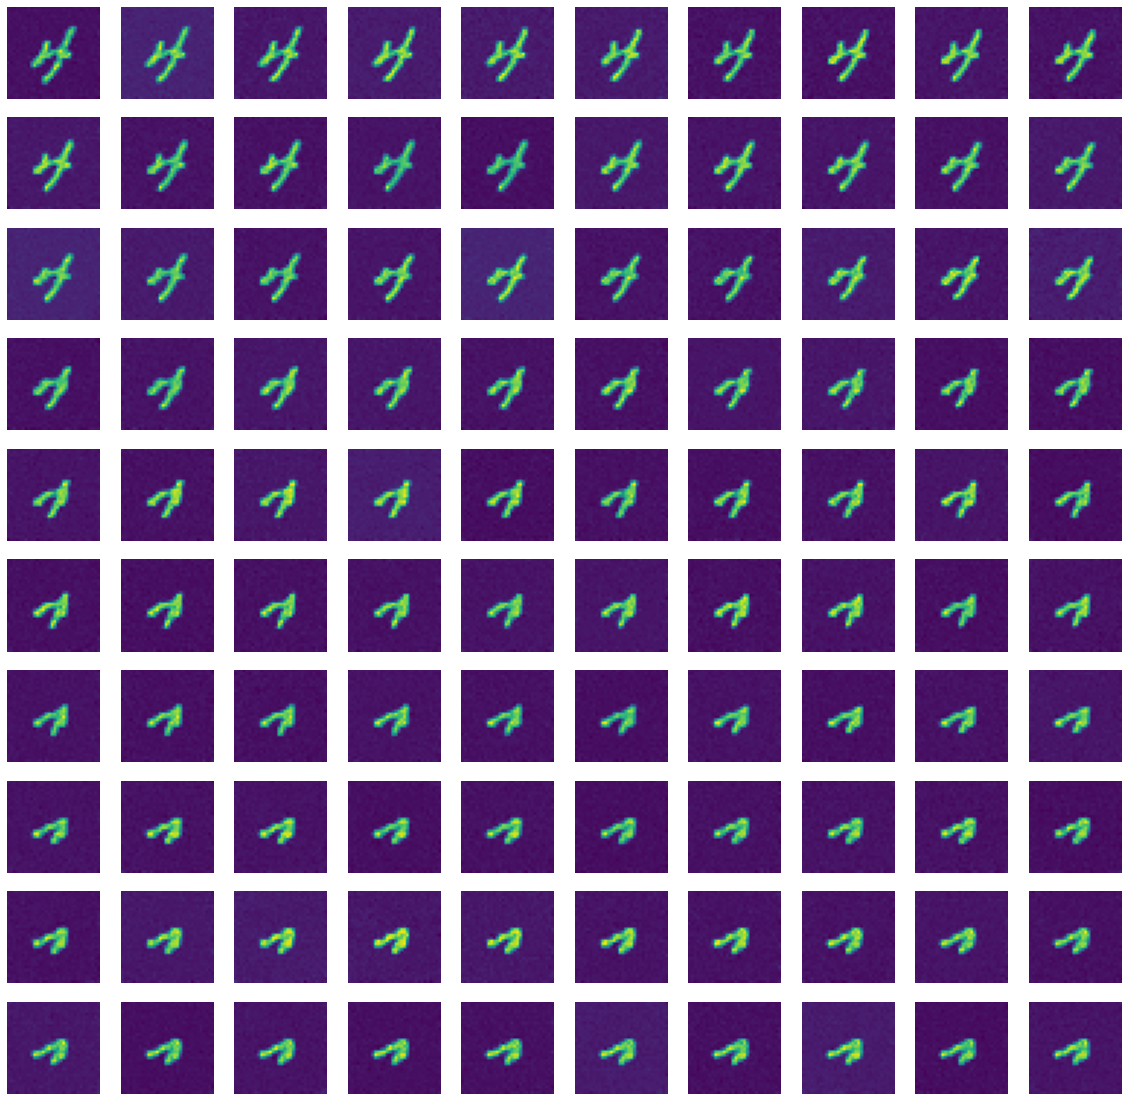

In [ ]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')

In [ ]:
num_results = int(1e5)
num_burnin_steps = int(1e2)

In [ ]:
 @jax.jit
def get_samples_mala():
    # First running SHMC
    kernel_shmc = ScoreMetropolisAdjustedLangevinAlgorithm(
            target_score_fn=score_fn,
            num_delta_logp_steps=8,
            step_size=0.0001)
 
    samples_shmc, is_accepted_shmc = tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state=batch['x'][5,...,0].reshape((32*32,)), #0.5*randn(32,32).reshape((32*32,)),
          kernel=kernel_shmc,
          trace_fn=lambda _, pkr: pkr.is_accepted, 
          seed=jax.random.PRNGKey(1))
    return samples_shmc, is_accepted_shmc 
 
samples_smala, is_accepted_smala = get_samples_mala()

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [ ]:
 len(where(is_accepted_smala)[0])

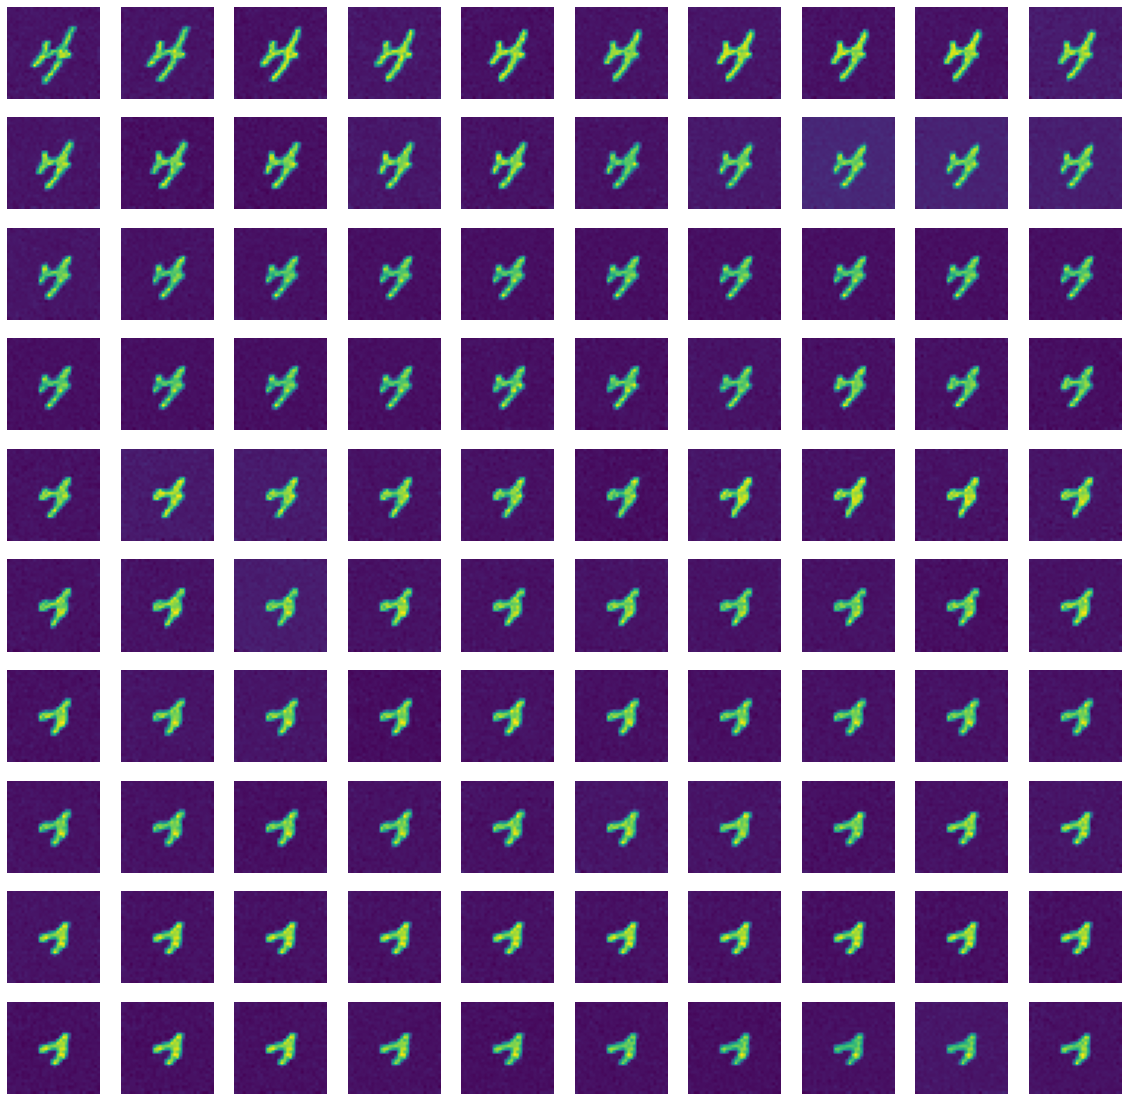

In [ ]:
 figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_smala[(10*i+j)*1000].reshape((32,32)))
    axis('off')